In [5]:
import os
import numpy as np
%run ../../src/dsen2/utils/DSen2Net.py

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
MDL_PATH = "../../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
model.load_weights(predict_file)

In [94]:
test_data = []
files = [x for x in os.listdir("../../data/test-raw/") if ".npy" in x]
for file in files:
    test_data.append(np.load("../../data/test-raw/" + file)[:5])
test_data = np.concatenate(test_data, axis = 0)
test_data = np.float32(test_data) / 65535
print(test_data.shape)

(5504, 48, 48, 10)


In [95]:
from skimage.transform import resize

def downPixelAggr(img, SCALE=2):
    from scipy import signal
    import skimage.measure
    from scipy.ndimage.filters import gaussian_filter
    img = resize(img, ((24, 24, 6)), 0)

    img_blur = np.zeros(img.shape)
    # Filter the image with a Gaussian filter
    for i in range(0, img.shape[2]):
        img_blur[:, :, i] = gaussian_filter(img[:, :, i], 1/SCALE)
    # New image dims
    new_dims = tuple(s//SCALE for s in img.shape)
    img_lr = np.zeros(new_dims[0:2]+(img.shape[-1],))
    # Iterate through all the image channels with avg pooling (pixel aggregation)
    for i in range(0, img.shape[2]):
        img_lr[:, :, i] = skimage.measure.block_reduce(img_blur[:, :, i], (SCALE, SCALE), np.mean)
        
    img_lr = resize(img_lr, ((48, 48, 6)), 0)

    return np.squeeze(img_lr)

def make_input_data(data):
    # 10 meter band, 20 -> 40 meter band, 20 meter band
    twentym = data[..., 4:]
    labels = np.copy(twentym)
    twentym = np.reshape(twentym, ((twentym.shape[0], 24, 2, 24, 2, 6)))
    twentym = np.mean(twentym, axis = (2, 4))
    tenm = data[..., :4]

    fourty_m = np.zeros_like(data[..., 4:])
    for sample in range(fourty_m.shape[0]):
        fourty_m[sample] = downPixelAggr(twentym[sample])

    bilinear_upsample = resize(fourty_m, (fourty_m.shape[0], 48, 48, 6), 2)
    input_data = np.concatenate([tenm, fourty_m], axis = -1)
    
    return bilinear_upsample, input_data, labels

def test_rmse(inp):
    label = np.copy(inp[..., 4:])
    inp_20m = inp[..., 4:]
    inp_40m = np.reshape(inp_20m, (24, 2, 24, 2, 6))
    inp_40m = np.mean(inp_40m, axis = (2, 4))
    
    fourty_m = downPixelAggr(inp_40m)
    inp[..., 4:] = fourty_m
    
    supered = np.squeeze(superresolve(inp[np.newaxis], model))
    se = (supered[..., 4:] - label)**2
    mse = np.mean(se, axis = (0, 1))
    rmse = np.sqrt(mse)
    return rmse
    

In [96]:
rmses = np.empty((len(test_data), 6))
for i in range(0, len(test_data)):
    rmse = test_rmse(test_data[i])
    print(i, rmse)
    rmses[i] = rmse

0 [0.07886478 0.02209584 0.02352912 0.04958569 0.07260974 0.04822468]
1 [0.08499094 0.03058358 0.02518029 0.04301771 0.08690862 0.04198262]
2 [0.08429284 0.03773227 0.02730234 0.03911214 0.09920608 0.04064334]
3 [0.08438905 0.03962322 0.02472258 0.03389917 0.10298663 0.04565803]
4 [0.07652868 0.0326855  0.02154654 0.03110729 0.09380678 0.0409484 ]
5 [0.12431102 0.04281687 0.11650794 0.12968653 0.06990682 0.11393499]
6 [0.11926683 0.03182623 0.09996577 0.11493444 0.06986091 0.10479268]
7 [0.08811093 0.02540281 0.05352202 0.07342156 0.05556257 0.08234524]
8 [0.07269071 0.02443021 0.03519922 0.05294872 0.05340072 0.06855918]
9 [0.05364719 0.02320469 0.01554866 0.03022716 0.05169138 0.0396533 ]
10 [0.03779349 0.03400393 0.03292613 0.03319707 0.05830261 0.03843205]
11 [0.03877339 0.03420373 0.03208373 0.03212681 0.05996062 0.04250179]
12 [0.035197   0.03157019 0.03005537 0.03082334 0.05642036 0.03730648]
13 [0.03848608 0.03524509 0.03350788 0.03300646 0.05919812 0.03939959]
14 [0.03883942 0

118 [0.08221146 0.07204434 0.0634183  0.06371003 0.12381514 0.11404382]
119 [0.07608679 0.06641945 0.05929258 0.0575888  0.12192971 0.08871403]
120 [0.06449211 0.0470176  0.05405816 0.06973439 0.0593896  0.04031179]
121 [0.06549674 0.04547435 0.05048285 0.06342537 0.0678133  0.03827805]
122 [0.0559657  0.04102199 0.04999989 0.06790553 0.04362068 0.04304026]
123 [0.06850529 0.04231841 0.04331879 0.05836096 0.08101796 0.04109837]
124 [0.05822743 0.03565886 0.04213346 0.06244737 0.04859675 0.04369185]
125 [0.06683917 0.04156408 0.02397266 0.01919761 0.08962342 0.04944265]
126 [0.06905775 0.04374371 0.02962557 0.02638756 0.09783281 0.05091104]
127 [0.07572728 0.04474998 0.02896447 0.01774246 0.097003   0.06286687]
128 [0.08901305 0.05612967 0.04509989 0.03736934 0.10284363 0.12953585]
129 [0.0817822  0.0512545  0.03806524 0.02934931 0.10394799 0.06497408]
130 [0.03440464 0.0238346  0.01135408 0.0163142  0.0514355  0.01039094]
131 [0.02944713 0.02147509 0.0104939  0.01525661 0.05154139 0.01

233 [0.03689829 0.03505172 0.03102713 0.03000217 0.05460233 0.04024044]
234 [0.03671449 0.03405703 0.03177175 0.030484   0.05081734 0.0338282 ]
235 [0.09873847 0.11739353 0.14293978 0.1512366  0.06448995 0.12143869]
236 [0.10335109 0.10957634 0.13625503 0.14689565 0.05716312 0.11709166]
237 [0.13621694 0.10409039 0.17816773 0.19268724 0.08263945 0.15776591]
238 [0.14728947 0.11233766 0.1942578  0.20692186 0.08759479 0.16169652]
239 [0.15277086 0.09648237 0.19587284 0.2092614  0.09211684 0.16300866]
240 [0.10896534 0.08844117 0.12778147 0.14257969 0.0568991  0.13086893]
241 [0.13541365 0.07768378 0.14551236 0.16052054 0.10715995 0.16268833]
242 [0.11497276 0.05989367 0.10358341 0.12580663 0.1229004  0.16009544]
243 [0.10318094 0.06815699 0.10110388 0.11251383 0.05754932 0.0712937 ]
244 [0.12397298 0.04204254 0.09132591 0.10830071 0.06486774 0.09348002]
245 [0.06256454 0.05106149 0.04045533 0.03281203 0.11099106 0.04561396]
246 [0.07272618 0.05762817 0.04712683 0.03964751 0.12940568 0.05

347 [0.02180343 0.04412142 0.05150069 0.05483    0.04448767 0.07546288]
348 [0.14912167 0.10017104 0.16091427 0.18185979 0.08367833 0.17882998]
349 [0.17457119 0.10807273 0.18585531 0.20448823 0.09101976 0.1949215 ]
350 [0.11847974 0.0498989  0.11097416 0.14031292 0.04534935 0.12948632]
351 [0.04321085 0.04570776 0.06595621 0.07671922 0.03267936 0.04860055]
352 [0.11101761 0.03915799 0.0933769  0.12247492 0.03406567 0.11806846]
353 [0.11046042 0.03913786 0.09300902 0.12117509 0.03287035 0.11763038]
354 [0.1590888  0.11832593 0.1216536  0.13895825 0.09808437 0.14994381]
355 [0.08334871 0.04441433 0.07349923 0.09191321 0.05668168 0.09129755]
356 [0.0739321  0.04066569 0.06456462 0.08232073 0.05119319 0.08191441]
357 [0.08654706 0.04511396 0.07258724 0.09289006 0.0583677  0.09349497]
358 [0.08249627 0.04070814 0.06863651 0.08730312 0.05753292 0.08967925]
359 [0.08682535 0.04085131 0.0696587  0.08913764 0.06068575 0.09220724]
360 [0.02690084 0.0175409  0.02088795 0.04219494 0.03868172 0.05

462 [0.05733163 0.04931344 0.03656131 0.02389937 0.10218417 0.03975334]
463 [0.05675092 0.04870418 0.03572984 0.02300044 0.10262239 0.0366956 ]
464 [0.05542355 0.0494135  0.03588283 0.02328564 0.10359961 0.03539481]
465 [0.12113424 0.06643085 0.11733678 0.14015073 0.0528989  0.12939997]
466 [0.12236723 0.06354817 0.11773118 0.13957919 0.04911229 0.1272873 ]
467 [0.11869108 0.06798592 0.11679037 0.14012207 0.05247704 0.1299842 ]
468 [0.11933633 0.06034403 0.1114913  0.13371283 0.04444815 0.12169545]
469 [0.11558293 0.06210872 0.10903992 0.13293357 0.04490475 0.12132557]
470 [0.11724208 0.06247192 0.11101244 0.13202603 0.04498077 0.11611787]
471 [0.11599882 0.06788003 0.10968388 0.13508621 0.04703209 0.119018  ]
472 [0.11314199 0.07124513 0.11254957 0.1354875  0.04809371 0.1223506 ]
473 [0.10946599 0.05635026 0.10085639 0.12042975 0.04233112 0.10708515]
474 [0.11436527 0.0649185  0.10507667 0.12931554 0.04457109 0.11896249]
475 [0.11465635 0.02715854 0.01478236 0.0373759  0.09378902 0.02

578 [0.08388387 0.07151757 0.04899069 0.02257573 0.15026823 0.060235  ]
579 [0.07989969 0.06889094 0.04678194 0.01888017 0.14722838 0.05831808]
580 [0.12343981 0.05137563 0.10651608 0.14093986 0.04236317 0.12972401]
581 [0.12142455 0.04377376 0.1041117  0.13614798 0.03939665 0.12341922]
582 [0.12117076 0.04880256 0.10375312 0.14019768 0.04301078 0.12841924]
583 [0.11508505 0.04221181 0.09550548 0.13147753 0.03821591 0.12095545]
584 [0.11566508 0.03666829 0.09843585 0.13401866 0.03823599 0.12305355]
585 [0.04047237 0.04294512 0.04359433 0.05191243 0.03858127 0.03701777]
586 [0.03451955 0.03053369 0.03023897 0.04006025 0.06734069 0.04192678]
587 [0.02961926 0.02371909 0.02323484 0.03146334 0.05230046 0.02822004]
588 [0.05047399 0.03876327 0.03549    0.04187937 0.08571423 0.04604221]
589 [0.0407451  0.02427071 0.02580117 0.03740157 0.05047544 0.02775672]
590 [0.064133   0.04015661 0.03164706 0.0349657  0.08792841 0.0561123 ]
591 [0.06303989 0.03915289 0.03224433 0.03585093 0.08477943 0.04

693 [0.09936291 0.03605525 0.07555003 0.10434085 0.03798492 0.10314157]
694 [0.11412953 0.03581548 0.07796723 0.1096532  0.05387162 0.10803448]
695 [0.06504901 0.04297002 0.0426035  0.05393194 0.08045243 0.0521764 ]
696 [0.06931539 0.04740969 0.04754378 0.05746988 0.08182881 0.05706345]
697 [0.07452974 0.05786709 0.07517616 0.0929376  0.0472866  0.07670056]
698 [0.08557407 0.06128659 0.08339155 0.10007161 0.04511769 0.08943566]
699 [0.1286607  0.08050546 0.1278771  0.14873244 0.06495424 0.13877895]
700 [0.06168874 0.04986203 0.03079655 0.01385139 0.1078145  0.03563617]
701 [0.06117957 0.05457009 0.03256007 0.01603587 0.10984248 0.03800512]
702 [0.04447894 0.03978269 0.02784343 0.02826551 0.08939709 0.04376795]
703 [0.02604055 0.03470338 0.03396163 0.04610712 0.07696509 0.06983592]
704 [0.04961667 0.02587394 0.01421781 0.0219885  0.08104227 0.04110973]
705 [0.0650936  0.0430842  0.03254769 0.02187647 0.09960411 0.04198275]
706 [0.06203239 0.04241014 0.03175859 0.02018289 0.09653754 0.04

809 [0.02250817 0.01528788 0.01262517 0.01547237 0.02375324 0.0113321 ]
810 [0.12936139 0.12707888 0.12807766 0.12934203 0.19032058 0.22139041]
811 [0.04804109 0.02991303 0.02106888 0.02285115 0.07955846 0.01677473]
812 [0.06317074 0.04434429 0.03201509 0.01986531 0.10912166 0.02778109]
813 [0.0781574  0.02403955 0.02217511 0.03184003 0.07641291 0.01812073]
814 [0.08830468 0.02514862 0.04237322 0.05857053 0.04818261 0.05804971]
815 [0.07621073 0.04572031 0.05442198 0.07249403 0.05652766 0.05112124]
816 [0.11122871 0.08458231 0.09083292 0.11050314 0.12290528 0.10380241]
817 [0.08095344 0.04688716 0.05400113 0.07409715 0.0661279  0.05199588]
818 [0.08755373 0.0437125  0.04999934 0.06999935 0.07213432 0.05012087]
819 [0.08668977 0.04244758 0.05132822 0.07252035 0.06126804 0.05347433]
820 [0.12314454 0.06722978 0.11739848 0.15802795 0.05083403 0.14929684]
821 [0.11860475 0.04322394 0.10215379 0.13811123 0.03255393 0.13892618]
822 [0.1234782  0.0552777  0.1042958  0.14877212 0.03664744 0.15

924 [0.06533895 0.05335668 0.04136889 0.03137797 0.11959818 0.03691771]
925 [0.09781951 0.06456514 0.11724345 0.14339924 0.05336937 0.10457568]
926 [0.04247356 0.01784373 0.04514758 0.05609116 0.02111623 0.05120318]
927 [0.10821348 0.04341381 0.09698283 0.12539633 0.03660937 0.11202864]
928 [0.1070071  0.04494504 0.09774113 0.12644583 0.03775137 0.11270058]
929 [0.10611042 0.03991082 0.09704647 0.12360282 0.03383511 0.10753033]
930 [0.11450202 0.03999109 0.09471096 0.12263573 0.03171539 0.11341163]
931 [0.08597936 0.02370362 0.06203824 0.08968336 0.01162924 0.0838923 ]
932 [0.09931585 0.02787507 0.07278026 0.09672579 0.01385065 0.08775699]
933 [0.10335821 0.03578177 0.08127134 0.10912473 0.02143344 0.10468412]
934 [0.10879045 0.03086111 0.0826949  0.10777634 0.01718784 0.09942116]
935 [0.06833856 0.03566093 0.02676701 0.03655667 0.0843729  0.02786368]
936 [0.07425688 0.0406882  0.0288505  0.02916707 0.10122299 0.03030468]
937 [0.07545147 0.04419282 0.03150918 0.0249465  0.10774095 0.03

1040 [0.06189942 0.04649936 0.06642121 0.07669983 0.03032725 0.06807903]
1041 [0.06940117 0.0322622  0.0540512  0.07377555 0.03398931 0.07465   ]
1042 [0.07040088 0.02870899 0.04766996 0.06605043 0.04027844 0.06148592]
1043 [0.07513345 0.03287628 0.04995554 0.07177667 0.05294799 0.06745534]
1044 [0.09721725 0.09098064 0.128607   0.1561617  0.07851893 0.13735855]
1045 [0.11005461 0.07846771 0.12350392 0.15592104 0.082747   0.15150851]
1046 [0.10173781 0.07262004 0.11702433 0.15018483 0.07679713 0.13761549]
1047 [0.09759233 0.07110523 0.11309141 0.14497706 0.07041853 0.12248997]
1048 [0.08808596 0.07472309 0.11431497 0.14558245 0.0637229  0.1042907 ]
1049 [0.05070229 0.02209865 0.0336884  0.04730071 0.02692446 0.04422718]
1050 [0.04903834 0.01971615 0.02983912 0.04152812 0.02901906 0.03616725]
1051 [0.0410658  0.01632091 0.02670639 0.04094705 0.02371329 0.04167463]
1052 [0.0469984  0.02005156 0.02863553 0.04025379 0.03103649 0.03502436]
1053 [0.04467198 0.0218682  0.02938691 0.04156474 0

1153 [0.03106852 0.02981903 0.02426368 0.02060163 0.04627702 0.03191984]
1154 [0.07510747 0.0622032  0.04751564 0.0293267  0.11876509 0.07683678]
1155 [0.06922231 0.05759707 0.04364637 0.02547761 0.11817347 0.0643364 ]
1156 [0.07447881 0.06186681 0.0466869  0.02800171 0.11875124 0.07710923]
1157 [0.07051948 0.0595518  0.04542503 0.02614166 0.12075039 0.06914751]
1158 [0.07200107 0.06127432 0.04433689 0.02587349 0.11710846 0.07682493]
1159 [0.04322997 0.02122775 0.01360825 0.02746927 0.05899945 0.02973007]
1160 [0.04253902 0.02321952 0.01448187 0.02548506 0.06161418 0.02699834]
1161 [0.04212745 0.02244795 0.01292978 0.02318002 0.05586619 0.02271653]
1162 [0.04272684 0.0253366  0.01657201 0.02417593 0.06237978 0.02593452]
1163 [0.04011147 0.02448523 0.01671536 0.02420638 0.0596304  0.02202301]
1164 [0.08141392 0.05412518 0.04118578 0.02463636 0.13315527 0.06358033]
1165 [0.08061195 0.05928515 0.04206088 0.02830983 0.13292535 0.07346192]
1166 [0.08493178 0.06055705 0.04626649 0.02680835 0

1267 [0.08419438 0.02050562 0.03775449 0.06183992 0.06835641 0.07509449]
1268 [0.08244437 0.01984395 0.03630158 0.06015092 0.06463847 0.06970459]
1269 [0.04844351 0.0397974  0.03339907 0.02765366 0.06670816 0.02690041]
1270 [0.0489504  0.0425653  0.03602649 0.02713069 0.07193865 0.0321194 ]
1271 [0.09280599 0.08443853 0.07859317 0.07179542 0.09084193 0.12778619]
1272 [0.06295839 0.05202963 0.0404416  0.02937896 0.09016118 0.0542235 ]
1273 [0.06255711 0.03858465 0.03019162 0.02220255 0.08036744 0.03499407]
1274 [0.07445686 0.07944597 0.07136965 0.07148609 0.10921507 0.12820655]
1275 [0.0245136  0.02552992 0.02288798 0.02081076 0.0380997  0.04344244]
1276 [0.06416997 0.06851365 0.06442592 0.06165894 0.10144801 0.1158014 ]
1277 [0.04551642 0.0283622  0.01907496 0.01357318 0.07288501 0.0201201 ]
1278 [0.08007337 0.03662229 0.0615861  0.07651076 0.01423162 0.07962642]
1279 [0.0891678  0.03527258 0.07440478 0.10175407 0.02960521 0.0952257 ]
1280 [0.0866762  0.03720382 0.07440554 0.10134674 0

1380 [0.0956893  0.06461099 0.09416864 0.10037591 0.05625869 0.0673133 ]
1381 [0.04967806 0.05058358 0.06772786 0.07104823 0.0278202  0.03507741]
1382 [0.06905915 0.03412587 0.0383148  0.04927825 0.07358809 0.04777746]
1383 [0.0821953  0.02758078 0.03536611 0.04181664 0.07277945 0.04461334]
1384 [0.03307158 0.02607602 0.02193604 0.02030433 0.04989154 0.03551544]
1385 [0.03569143 0.02768302 0.02088257 0.017551   0.04935737 0.0396156 ]
1386 [0.03334941 0.02615412 0.02091611 0.01566073 0.04953243 0.03844474]
1387 [0.04287895 0.03161191 0.02378987 0.01780978 0.05496978 0.04848636]
1388 [0.03717724 0.02651607 0.01660512 0.01289146 0.04844678 0.03379994]
1389 [0.1130312  0.06335693 0.10029078 0.11661503 0.03715763 0.1141256 ]
1390 [0.07913083 0.02018991 0.01830662 0.03768613 0.06769006 0.0338768 ]
1391 [0.07082608 0.02751534 0.01569373 0.03142285 0.07999989 0.02757731]
1392 [0.07023702 0.033829   0.01869848 0.02696299 0.09129579 0.02447425]
1393 [0.069401   0.03726041 0.02087894 0.024569   0

1493 [0.0703755  0.0254849  0.05747078 0.08117203 0.01449724 0.07692792]
1494 [0.05684292 0.05742992 0.06831861 0.07841183 0.0363374  0.06380584]
1495 [0.08769467 0.06250679 0.08293203 0.09342316 0.03848867 0.07037161]
1496 [0.08613751 0.06175393 0.08485702 0.09486683 0.03368939 0.07058574]
1497 [0.11331841 0.06749136 0.11974287 0.13379544 0.06776539 0.1299312 ]
1498 [0.1180735  0.06977858 0.12884727 0.14603658 0.0716658  0.1347991 ]
1499 [0.0383804  0.03260097 0.03732081 0.04140906 0.03712406 0.04429705]
1500 [0.04276248 0.03011872 0.03695385 0.03854882 0.03513163 0.04283032]
1501 [0.0372866  0.02954399 0.03511892 0.03755289 0.0270629  0.04505693]
1502 [0.0471122  0.03351814 0.04139802 0.04316534 0.03106374 0.0444392 ]
1503 [0.04736547 0.04213257 0.05143166 0.05261106 0.0329658  0.05657242]
1504 [0.16602221 0.15725684 0.1550923  0.16047932 0.1319811  0.1407392 ]
1505 [0.14224635 0.13923424 0.13944097 0.14844058 0.13529697 0.14900889]
1506 [0.18333378 0.17651656 0.1749327  0.18301986 0

1608 [0.09473515 0.02226448 0.04934902 0.06976714 0.05752492 0.07517674]
1609 [0.09394529 0.02541891 0.04710094 0.0734687  0.06233973 0.07461929]
1610 [0.09241848 0.02328701 0.04616648 0.07357852 0.05892938 0.07519349]
1611 [0.08967409 0.02509248 0.04046622 0.06578524 0.06761643 0.06675316]
1612 [0.08923004 0.02483574 0.03494691 0.05969616 0.07193723 0.06084202]
1613 [0.0840179  0.02702449 0.03562193 0.0614223  0.07293154 0.06226639]
1614 [0.08117422 0.04801981 0.03075455 0.01832897 0.10157529 0.0477649 ]
1615 [0.07994521 0.04466896 0.02900799 0.02198339 0.10039993 0.03311811]
1616 [0.07830669 0.04333409 0.0277659  0.02062809 0.09863023 0.03228937]
1617 [0.07867648 0.04424248 0.02693178 0.01755866 0.0966721  0.03897474]
1618 [0.07783167 0.04444386 0.02590731 0.01650927 0.09732214 0.03643157]
1619 [0.09450622 0.06423716 0.04448405 0.0362795  0.12941886 0.07252237]
1620 [0.09689836 0.06857894 0.04512518 0.03387235 0.12965536 0.0835709 ]
1621 [0.09325233 0.06480947 0.04649713 0.03966204 0

1722 [0.06630804 0.05113958 0.03860602 0.03587754 0.11089171 0.03901458]
1723 [0.06131944 0.04689092 0.03500189 0.03155662 0.10395967 0.03528297]
1724 [0.06041767 0.04637145 0.03438116 0.03455633 0.10432951 0.0329297 ]
1725 [0.04209569 0.03813689 0.03946177 0.04172246 0.06118391 0.05140096]
1726 [0.05084296 0.03445567 0.03361855 0.03356793 0.05006617 0.02381312]
1727 [0.0543306  0.03305463 0.03314305 0.03313518 0.04943097 0.02902987]
1728 [0.05316642 0.02880319 0.02724384 0.02695689 0.05224032 0.03073129]
1729 [0.06146939 0.03443713 0.03606193 0.03606901 0.05026294 0.03291648]
1730 [0.08859955 0.04107039 0.08316456 0.10421293 0.0322727  0.08958396]
1731 [0.08718652 0.04146587 0.0812737  0.10428044 0.02982103 0.09267602]
1732 [0.08063276 0.03592847 0.07570958 0.09628947 0.03191346 0.08886013]
1733 [0.08284598 0.03697602 0.07554938 0.09761729 0.02935106 0.09083131]
1734 [0.07333245 0.03340967 0.06882346 0.08909225 0.02828116 0.08839284]
1735 [0.09016796 0.08028114 0.11234717 0.13114733 0

1836 [0.07355581 0.06487077 0.05347861 0.0462481  0.13026865 0.08893237]
1837 [0.07115752 0.05981538 0.05138715 0.04329964 0.12692527 0.07473648]
1838 [0.0740752  0.06641488 0.05423643 0.04688891 0.1322937  0.08989292]
1839 [0.07379583 0.0553763  0.0478877  0.0410516  0.11927336 0.0729836 ]
1840 [0.08982703 0.05619256 0.09100536 0.11352942 0.04459329 0.10125984]
1841 [0.08480825 0.06282396 0.09897085 0.12550297 0.05732103 0.12443932]
1842 [0.08887936 0.05182921 0.08751385 0.11439958 0.04501039 0.11496325]
1843 [0.10828844 0.03744337 0.0969229  0.12722372 0.03595593 0.11708928]
1844 [0.13850905 0.03613685 0.11426678 0.15657689 0.02847508 0.14202966]
1845 [0.13175112 0.08385069 0.10305315 0.12544042 0.08689661 0.14956005]
1846 [0.08078152 0.06407069 0.0790976  0.08467067 0.0660563  0.09726323]
1847 [0.08519024 0.04613488 0.07792928 0.10321386 0.04856044 0.10037889]
1848 [0.06679039 0.04985875 0.03480698 0.0334861  0.12810493 0.04725232]
1849 [0.05931255 0.04054402 0.03445653 0.03238023 0

1950 [0.09184684 0.03655385 0.05307439 0.07606654 0.06416558 0.0622545 ]
1951 [0.09378628 0.03617065 0.04997877 0.07122793 0.06879418 0.05588999]
1952 [0.08612524 0.03641417 0.04824083 0.06936818 0.06617144 0.05256942]
1953 [0.07292148 0.01429051 0.03450568 0.06346773 0.0299191  0.06202284]
1954 [0.06616268 0.01201839 0.02710169 0.05394201 0.03593582 0.05298268]
1955 [0.06075317 0.01241525 0.02080147 0.04556527 0.0422762  0.04157658]
1956 [0.04309362 0.03422878 0.03638039 0.04447883 0.04667029 0.01732189]
1957 [0.04230158 0.03373094 0.03456116 0.04187264 0.04947951 0.01821228]
1958 [0.10370606 0.07831782 0.0663109  0.05485664 0.1507414  0.0909771 ]
1959 [0.10788735 0.0817501  0.06360111 0.04801457 0.14804626 0.10528715]
1960 [0.10262689 0.07551936 0.06061751 0.04374241 0.14660236 0.08644901]
1961 [0.10769709 0.06549231 0.0527938  0.0435917  0.13111816 0.08009166]
1962 [0.11320432 0.06740906 0.04985533 0.04130348 0.13289538 0.09204522]
1963 [0.10466355 0.01994501 0.05243337 0.08144464 0

2064 [0.14930815 0.12627614 0.10693651 0.07361303 0.20363776 0.19629234]
2065 [0.11613408 0.0963952  0.08265534 0.05607947 0.13231002 0.12869631]
2066 [0.29229307 0.28846425 0.28347847 0.27747732 0.50107384 0.49034774]
2067 [0.3319554  0.3250431  0.31461585 0.3060061  0.43073425 0.42497742]
2068 [0.05066212 0.03184274 0.01799975 0.00894064 0.07174556 0.02750933]
2069 [0.05861067 0.0358496  0.02634463 0.01347705 0.08484454 0.03579418]
2070 [0.06200681 0.04338453 0.02707376 0.01582243 0.08661965 0.04884023]
2071 [0.05982273 0.03774095 0.02063839 0.01156911 0.07841969 0.03954624]
2072 [0.06136272 0.03111401 0.02049673 0.01039439 0.07808467 0.02974766]
2073 [0.07375809 0.07329775 0.07797877 0.09768101 0.0345378  0.07305258]
2074 [0.07768518 0.06855392 0.06238813 0.0647205  0.09711426 0.03356683]
2075 [0.08584582 0.07651862 0.06967311 0.07027052 0.10713949 0.03724095]
2076 [0.07865617 0.06949288 0.06242222 0.06086062 0.10043526 0.03367361]
2077 [0.08500457 0.07533061 0.06737915 0.06415328 0

2179 [0.05233139 0.03608797 0.03799979 0.04805299 0.0510655  0.03945056]
2180 [0.05170062 0.03513519 0.036135   0.04483969 0.05467345 0.03549291]
2181 [0.05155356 0.03628062 0.03747853 0.04736593 0.05120392 0.03814372]
2182 [0.05217044 0.0358486  0.03522381 0.04379049 0.05498977 0.03388924]
2183 [0.06345552 0.04791485 0.03703213 0.03733526 0.09433014 0.01868034]
2184 [0.05829281 0.04525416 0.0359589  0.03968038 0.08756243 0.02271956]
2185 [0.05873759 0.04579145 0.0341886  0.03491679 0.09001688 0.01864826]
2186 [0.05940147 0.04598803 0.03608806 0.03965258 0.088963   0.02253259]
2187 [0.06134757 0.04801528 0.03621597 0.03371647 0.094177   0.01965428]
2188 [0.09009965 0.05994816 0.09167604 0.11801506 0.04977405 0.12598889]
2189 [0.10051685 0.06002576 0.09660546 0.12246072 0.05183483 0.12434103]
2190 [0.10269301 0.06133869 0.10068993 0.12558572 0.05129043 0.12185782]
2191 [0.10300043 0.06310313 0.10090706 0.12717068 0.05185397 0.11803941]
2192 [0.09916683 0.06463817 0.10196035 0.12576894 0

2293 [0.07111407 0.06222987 0.05287785 0.03528043 0.10799254 0.11058217]
2294 [0.06999187 0.0611854  0.05346208 0.03988366 0.10172264 0.10063969]
2295 [0.05561891 0.04757005 0.0407989  0.0267697  0.08774698 0.07824517]
2296 [0.06969656 0.05567299 0.0474273  0.03361435 0.09456074 0.10766935]
2297 [0.06941826 0.0460819  0.03727341 0.02399269 0.08702318 0.07775949]
2298 [0.07123045 0.05629634 0.05812242 0.07304892 0.07292565 0.03962513]
2299 [0.07684058 0.05817685 0.0565959  0.0682971  0.08191919 0.03195718]
2300 [0.078266   0.05838891 0.06077409 0.07492729 0.07256904 0.03758643]
2301 [0.1446365  0.09167526 0.14597753 0.17108102 0.07129864 0.16619638]
2302 [0.14694966 0.08344913 0.14640366 0.17502557 0.06630263 0.16295883]
2303 [0.12370696 0.06079249 0.10659929 0.13205288 0.03366515 0.12911157]
2304 [0.11284284 0.0571816  0.09554842 0.12070816 0.03019964 0.11938632]
2305 [0.11449107 0.05174622 0.09536298 0.117617   0.03028104 0.11233285]
2306 [0.12799141 0.06491887 0.10977581 0.13621323 0

2406 [0.09983266 0.04049093 0.08735887 0.11279229 0.03263234 0.09901346]
2407 [0.10426649 0.0470251  0.09144882 0.11766852 0.03759336 0.10345113]
2408 [0.25749713 0.25916597 0.24025914 0.23128703 0.35384822 0.3421639 ]
2409 [0.27833766 0.275048   0.25732973 0.23170027 0.3827667  0.38050112]
2410 [0.2758556  0.26648423 0.24415873 0.21752152 0.38119626 0.38592064]
2411 [0.28703207 0.25996238 0.21858992 0.17186543 0.3938852  0.4010017 ]
2412 [0.22339304 0.2021854  0.16700536 0.12808838 0.3066223  0.3205128 ]
2413 [0.12671629 0.0632378  0.13751788 0.15518284 0.07983164 0.14258605]
2414 [0.07388975 0.02339576 0.03035484 0.05115459 0.06118213 0.07011041]
2415 [0.05484421 0.03448799 0.01815885 0.01855175 0.07149064 0.03901892]
2416 [0.01737569 0.01990111 0.02941913 0.04537867 0.01579148 0.06466343]
2417 [0.06562377 0.04373341 0.02661181 0.01573112 0.08467573 0.05069427]
2418 [0.05187584 0.0420703  0.03615103 0.04456824 0.09385876 0.06970211]
2419 [0.04591417 0.03749304 0.03358962 0.03937447 0

2519 [0.06961522 0.02610445 0.04660929 0.06648242 0.054936   0.0680832 ]
2520 [0.06866322 0.02505952 0.04235638 0.06272078 0.05339235 0.06468867]
2521 [0.06519968 0.03618708 0.0521796  0.07017372 0.05304728 0.05880901]
2522 [0.07422934 0.02224717 0.0396591  0.06090684 0.05671148 0.06092291]
2523 [0.08245903 0.07331751 0.05582515 0.0391831  0.14367174 0.09608894]
2524 [0.08059918 0.07241091 0.05496122 0.03786527 0.14142878 0.09371782]
2525 [0.07609766 0.06375164 0.05038589 0.02990817 0.13848293 0.07101412]
2526 [0.08296    0.07644159 0.05839901 0.04013355 0.14683448 0.09751705]
2527 [0.07042227 0.06077179 0.04788733 0.02947395 0.13022777 0.0683956 ]
2528 [0.0597536  0.02651273 0.01861749 0.02243075 0.06715859 0.01691483]
2529 [0.05936851 0.03085094 0.01891636 0.0213298  0.06958437 0.0200379 ]
2530 [0.05737133 0.02944085 0.02052808 0.02142913 0.06941052 0.01831109]
2531 [0.0581457  0.03369809 0.02198172 0.02004258 0.07239853 0.0242957 ]
2532 [0.0562577  0.03221928 0.02343844 0.02143575 0

2632 [0.10618162 0.03000681 0.05845152 0.08175986 0.04055418 0.0743987 ]
2633 [0.12434314 0.05394713 0.09741879 0.12287986 0.0434382  0.11298108]
2634 [0.12476639 0.06109788 0.10402405 0.12716086 0.04126542 0.11543301]
2635 [0.12307448 0.05268073 0.09885238 0.11915187 0.04169313 0.10574961]
2636 [0.12776388 0.05485644 0.10357051 0.12364107 0.03967358 0.11368825]
2637 [0.1262675  0.06017442 0.10232793 0.12490888 0.04006964 0.1155356 ]
2638 [0.06536977 0.05771042 0.04065543 0.02720367 0.10803025 0.06975308]
2639 [0.05850679 0.05123119 0.03848747 0.02188757 0.10280316 0.05322602]
2640 [0.06366731 0.05707522 0.03963662 0.02579807 0.10693187 0.06732658]
2641 [0.05537712 0.04819288 0.03568253 0.02106431 0.09995747 0.04310893]
2642 [0.06494907 0.05695187 0.04063835 0.02650886 0.10830098 0.06889332]
2643 [0.05629054 0.02136812 0.01738527 0.02907828 0.05050113 0.02391542]
2644 [0.05549693 0.0227546  0.01711947 0.02893304 0.0573196  0.02357326]
2645 [0.04730094 0.01954524 0.01226605 0.02426829 0

2747 [0.05735127 0.04569261 0.03323587 0.01904132 0.09504563 0.04768356]
2748 [0.12178451 0.08836765 0.13828522 0.14126407 0.07878073 0.13862595]
2749 [0.15707473 0.09887138 0.17049374 0.17641364 0.09387437 0.16697389]
2750 [0.14947805 0.09595189 0.15944475 0.16958062 0.08851678 0.16000047]
2751 [0.13882008 0.09130514 0.15259688 0.16446058 0.08736151 0.1533976 ]
2752 [0.14016636 0.10102011 0.1487893  0.16381562 0.07894403 0.15014437]
2753 [0.064813   0.02333913 0.02753514 0.04084991 0.05914847 0.05260037]
2754 [0.11122241 0.05942683 0.1166127  0.127669   0.05246052 0.09828816]
2755 [0.11057159 0.0538362  0.10525125 0.11722057 0.05127293 0.09624133]
2756 [0.08892366 0.02851265 0.05980479 0.07653847 0.05910659 0.07415197]
2757 [0.06496832 0.02262959 0.02041638 0.03712175 0.06595511 0.05717992]
2758 [0.04018375 0.06513221 0.06976412 0.08008184 0.11500157 0.1155341 ]
2759 [0.03632278 0.06215057 0.06782731 0.07898037 0.10899503 0.11078818]
2760 [0.03353301 0.06219652 0.07177971 0.08722494 0

2861 [0.06283291 0.05414321 0.03996871 0.03124977 0.09756881 0.075584  ]
2862 [0.06330895 0.05173818 0.04249687 0.0308605  0.10197536 0.06753126]
2863 [0.12073277 0.05359228 0.09237096 0.11887094 0.0286674  0.1186531 ]
2864 [0.09724203 0.03588555 0.06271659 0.08575641 0.04358868 0.07562803]
2865 [0.09330371 0.04185124 0.05888741 0.08516402 0.0724602  0.0725226 ]
2866 [0.13741846 0.0642914  0.1164975  0.14507177 0.03989727 0.14304082]
2867 [0.14085649 0.05432171 0.11419776 0.14498448 0.03092126 0.13277073]
2868 [0.08651808 0.08371533 0.07780366 0.07108443 0.07708494 0.08588794]
2869 [0.06931264 0.05524807 0.05161111 0.04466081 0.08922645 0.08153626]
2870 [0.07393869 0.05781754 0.05517233 0.04933391 0.08865698 0.09101547]
2871 [0.09127119 0.05814894 0.0767976  0.07711378 0.07237474 0.09365648]
2872 [0.09172603 0.06129953 0.08076244 0.08040567 0.08034491 0.10075142]
2873 [0.05366734 0.03555483 0.04786766 0.06066887 0.03438474 0.04806011]
2874 [0.05113167 0.0365001  0.04850858 0.06158935 0

2975 [0.11205274 0.12233064 0.1629405  0.17641643 0.08122778 0.07568515]
2976 [0.10643136 0.09435386 0.12727198 0.13942951 0.05835123 0.05901011]
2977 [0.08536618 0.06697047 0.07975131 0.08779052 0.08854459 0.07797648]
2978 [0.06205006 0.0341068  0.02612972 0.02734595 0.07959996 0.0342034 ]
2979 [0.06982516 0.0401701  0.03041413 0.02887966 0.0873733  0.04494308]
2980 [0.07495383 0.05495293 0.04509553 0.03796726 0.10237768 0.04967679]
2981 [0.07717359 0.05682075 0.04385003 0.03426744 0.11003004 0.06700447]
2982 [0.07773889 0.05821165 0.0427171  0.02467269 0.11413416 0.06745137]
2983 [0.03398035 0.02833416 0.02532244 0.02429289 0.03669231 0.02925015]
2984 [0.02954988 0.02489605 0.02265957 0.02216653 0.0328132  0.02370428]
2985 [0.02634335 0.02194861 0.01833222 0.01819481 0.03129191 0.02156653]
2986 [0.02901473 0.02484856 0.02223507 0.02169507 0.03289792 0.02297199]
2987 [0.03344965 0.02832362 0.02442545 0.02295585 0.03705285 0.02820016]
2988 [0.03509712 0.02075658 0.01727884 0.02608099 0

3089 [0.1334344  0.03858858 0.08076695 0.10574183 0.04317855 0.09468592]
3090 [0.13025257 0.04416038 0.08346157 0.10955092 0.04225301 0.10151958]
3091 [0.1310479  0.03677476 0.07775757 0.10247976 0.04699571 0.09087121]
3092 [0.11750427 0.02820546 0.05424872 0.08390389 0.06562697 0.07288767]
3093 [0.08156295 0.06902017 0.05162607 0.02802022 0.15888917 0.06310073]
3094 [0.07711676 0.06289791 0.04772078 0.02468618 0.15357836 0.0491561 ]
3095 [0.08080044 0.06852961 0.05105095 0.02827919 0.1580229  0.06080322]
3096 [0.08256216 0.06745435 0.05032326 0.02620199 0.15795834 0.05828884]
3097 [0.07757315 0.06241064 0.04696539 0.02482229 0.15276472 0.04703756]
3098 [0.03281334 0.02450392 0.02385459 0.02592956 0.03844718 0.02916261]
3099 [0.03480927 0.02273843 0.01849095 0.01866362 0.04764111 0.02477049]
3100 [0.03279522 0.02360049 0.02484019 0.0326812  0.05331653 0.037687  ]
3101 [0.04110292 0.03484029 0.03512363 0.04371367 0.08118462 0.07096328]
3102 [0.041828   0.03960849 0.0399322  0.04841114 0

3203 [0.03791864 0.03486063 0.03187528 0.03439143 0.05281695 0.03161883]
3204 [0.03744187 0.0350334  0.03273725 0.03700083 0.04761967 0.03743936]
3205 [0.0357975  0.03317358 0.03075152 0.03409859 0.04942573 0.03402149]
3206 [0.03620452 0.0330429  0.03163981 0.03625437 0.04577507 0.03937226]
3207 [0.03827118 0.0361298  0.03295667 0.03589069 0.05286034 0.03245898]
3208 [0.04086662 0.05234606 0.06869936 0.07884922 0.02256582 0.06881977]
3209 [0.03994715 0.04815839 0.06418524 0.07390083 0.02121508 0.06209587]
3210 [0.03479675 0.04507278 0.05907906 0.07127152 0.01895805 0.06531019]
3211 [0.03346502 0.03944921 0.05242031 0.06457526 0.01678984 0.05741841]
3212 [0.03163327 0.03986966 0.05060815 0.06380159 0.01602684 0.0594148 ]
3213 [0.06541985 0.01649964 0.02410863 0.03399374 0.05749744 0.04076882]
3214 [0.06582537 0.02067838 0.03161401 0.04354612 0.04889252 0.0513944 ]
3215 [0.0694613  0.02038885 0.03163469 0.04449895 0.05051658 0.0526851 ]
3216 [0.08942168 0.02101455 0.03307047 0.04817142 0

3317 [0.24535656 0.23044641 0.20955561 0.19752035 0.41513675 0.41190344]
3318 [0.09141946 0.03697887 0.07176123 0.08820909 0.02531169 0.0830704 ]
3319 [0.08814654 0.03617807 0.06747858 0.08595823 0.02332323 0.08398382]
3320 [0.08696537 0.03073353 0.06422649 0.08153454 0.02328316 0.07733919]
3321 [0.08410554 0.0301281  0.06036843 0.07983754 0.02229987 0.07904799]
3322 [0.08194672 0.0234395  0.05422109 0.07209172 0.02422664 0.06930275]
3323 [0.3676076  0.32964948 0.25616395 0.18497203 0.56677705 0.56413096]
3324 [0.29343274 0.29281235 0.2695176  0.23888256 0.5463507  0.54392296]
3325 [0.28709543 0.26691118 0.23644148 0.20524941 0.49661708 0.49316752]
3326 [0.31380963 0.28556266 0.24467002 0.21328473 0.5234804  0.52008355]
3327 [0.32099283 0.29550794 0.25485924 0.219943   0.5364563  0.53438395]
3328 [0.08318862 0.03512046 0.06595547 0.09056362 0.03195648 0.08578148]
3329 [0.08364338 0.03322967 0.06633492 0.08937624 0.03230485 0.082425  ]
3330 [0.08372276 0.03338227 0.0661545  0.08998495 0

3432 [0.08772146 0.04383979 0.03050096 0.03740964 0.11530379 0.05224198]
3433 [0.10289751 0.03745725 0.06818152 0.08509584 0.02176951 0.07773325]
3434 [0.09686941 0.03468617 0.05919904 0.0785532  0.02688206 0.074195  ]
3435 [0.08856738 0.03892037 0.06556918 0.08353549 0.01842069 0.07875415]
3436 [0.09271467 0.04044205 0.06301848 0.08188967 0.02519173 0.07789131]
3437 [0.08411475 0.02393548 0.03338138 0.05292158 0.05819654 0.04198369]
3438 [0.08081324 0.03417224 0.03537132 0.05158842 0.06036827 0.03996204]
3439 [0.07556348 0.03110766 0.03335281 0.05016595 0.0566262  0.03520016]
3440 [0.07686064 0.03404216 0.03220408 0.04820812 0.0611443  0.03603508]
3441 [0.07520425 0.03338175 0.03340136 0.04892294 0.06024103 0.03485443]
3442 [0.07896922 0.03780438 0.03396724 0.04825788 0.06694739 0.03856539]
3443 [0.07623892 0.01416003 0.01522148 0.04446358 0.06803383 0.03938835]
3444 [0.08141439 0.01913304 0.0167138  0.05038972 0.07008142 0.04078686]
3445 [0.08197139 0.02332322 0.01463629 0.0452534  0

3546 [0.07556494 0.0436085  0.06027695 0.0702759  0.04375897 0.05916751]
3547 [0.07226314 0.0458816  0.05880774 0.0691785  0.0441862  0.05533295]
3548 [0.09218217 0.03376143 0.04353726 0.07614716 0.06799999 0.06553109]
3549 [0.08914706 0.0352549  0.04388901 0.07810315 0.06667902 0.06950345]
3550 [0.08960481 0.03857829 0.04398967 0.07464921 0.07026453 0.0619284 ]
3551 [0.08664239 0.04008973 0.04496479 0.07529248 0.06989523 0.06303508]
3552 [0.08783641 0.04145895 0.04266621 0.07021501 0.0734378  0.05588951]
3553 [0.27183107 0.25202894 0.22660711 0.21548052 0.44309708 0.4470814 ]
3554 [0.22434391 0.20588428 0.18268092 0.17207418 0.31144497 0.33591166]
3555 [0.13749586 0.13047385 0.11844484 0.11925673 0.17031366 0.20602573]
3556 [0.29165417 0.27361685 0.24894458 0.23222634 0.43334195 0.43158638]
3557 [0.31443548 0.29938224 0.27179468 0.24610347 0.5653351  0.55491954]
3558 [0.08302663 0.06383198 0.05317537 0.04984189 0.12091225 0.06005802]
3559 [0.08313363 0.06460012 0.05633487 0.05525826 0

3660 [0.05993034 0.03880886 0.03284399 0.03162291 0.07354273 0.04716951]
3661 [0.06460079 0.03859844 0.03224203 0.0310706  0.07399368 0.05080836]
3662 [0.06400064 0.02268069 0.02418881 0.03325341 0.05133142 0.04558135]
3663 [0.1023232  0.05315611 0.09554956 0.11883987 0.0418467  0.11382621]
3664 [0.09732681 0.04630341 0.08424132 0.11197213 0.03708084 0.11174039]
3665 [0.08712265 0.03692419 0.07309554 0.10120705 0.03403969 0.10801028]
3666 [0.12589577 0.05201597 0.10354687 0.1349358  0.03793905 0.13319547]
3667 [0.11422817 0.04894895 0.09502472 0.11820467 0.05350278 0.12228821]
3668 [0.08064173 0.03038725 0.02154183 0.03235395 0.08268091 0.02897994]
3669 [0.08234813 0.04088022 0.03730577 0.04866786 0.08701648 0.04128541]
3670 [0.07569943 0.02850975 0.02056598 0.03147733 0.08154413 0.0285222 ]
3671 [0.07755656 0.03116657 0.02023875 0.03028825 0.08128683 0.03005645]
3672 [0.07364629 0.02895669 0.01881461 0.03059142 0.07779945 0.02989754]
3673 [0.05250933 0.04732617 0.04224914 0.03450331 0

3774 [0.04756052 0.02362904 0.02372472 0.0457157  0.04510248 0.02691562]
3775 [0.04950895 0.025151   0.02474371 0.04679656 0.04897583 0.0288883 ]
3776 [0.04651965 0.02238808 0.02457485 0.0519891  0.03775519 0.03448154]
3777 [0.0414569  0.02086269 0.0215321  0.04321004 0.03775221 0.02850749]
3778 [0.02116694 0.00352751 0.00348904 0.00311054 0.01095567 0.01288094]
3779 [0.01855758 0.00358754 0.00342449 0.00278568 0.00926736 0.01315433]
3780 [0.01384935 0.00893441 0.0091162  0.00888516 0.01089055 0.01216184]
3781 [0.00851546 0.00415151 0.00447409 0.00494201 0.00490922 0.00720359]
3782 [0.00874171 0.0044813  0.00546601 0.00431529 0.00553983 0.00948574]
3783 [0.08600787 0.02615579 0.0522319  0.07687451 0.04598238 0.07789197]
3784 [0.08549126 0.023707   0.05011611 0.07494663 0.04897666 0.07494036]
3785 [0.07613063 0.02585297 0.04731502 0.07009954 0.04142495 0.06813987]
3786 [0.08051668 0.02172314 0.04112211 0.06647281 0.05586289 0.06909696]
3787 [0.07832737 0.02084408 0.03797119 0.06553546 0

3888 [0.02533888 0.01940999 0.01133779 0.00668286 0.03741282 0.01818103]
3889 [0.02921339 0.02169589 0.01241796 0.00795943 0.0403645  0.01975941]
3890 [0.04540892 0.01688836 0.02070687 0.03687654 0.0410032  0.03653044]
3891 [0.05609442 0.02527193 0.03030171 0.04698025 0.04499179 0.03974364]
3892 [0.04982619 0.02031455 0.02107535 0.0357061  0.0471169  0.03261191]
3893 [0.05318269 0.02256043 0.02732369 0.04432806 0.04253504 0.03784231]
3894 [0.05137248 0.0222823  0.02151861 0.03498408 0.04955315 0.02994109]
3895 [0.08722054 0.05166778 0.03299145 0.03768382 0.1208134  0.07313363]
3896 [0.08534917 0.05335486 0.03715304 0.04036401 0.1269679  0.07133356]
3897 [0.08170118 0.05448092 0.03338045 0.02836646 0.12383518 0.06885836]
3898 [0.08204867 0.05785801 0.03980019 0.03233723 0.1323592  0.0713253 ]
3899 [0.08260505 0.06043845 0.03755436 0.02506621 0.13099483 0.07443471]
3900 [0.09749418 0.05414997 0.03493456 0.03983571 0.11819752 0.0596927 ]
3901 [0.09425905 0.05025897 0.03656311 0.04644632 0

4002 [0.04698336 0.0414216  0.03592705 0.0329765  0.07101886 0.05303834]
4003 [0.04483014 0.03852551 0.03231668 0.02893982 0.06901234 0.05007214]
4004 [0.03955327 0.03369315 0.02819938 0.025495   0.0605407  0.04349134]
4005 [0.05380344 0.04929726 0.04627885 0.0447529  0.0692545  0.05755566]
4006 [0.0495632  0.04565975 0.0413037  0.04031619 0.06516792 0.06562978]
4007 [0.05359706 0.04927325 0.04593602 0.04421436 0.07033153 0.05861673]
4008 [0.04829909 0.0448687  0.04042337 0.03944596 0.06366225 0.06372669]
4009 [0.04959454 0.04660425 0.04175623 0.04067412 0.06727025 0.06716831]
4010 [0.05765371 0.02800986 0.01926671 0.03201013 0.07370105 0.028612  ]
4011 [0.05625153 0.02822023 0.01581673 0.02733741 0.07358029 0.02474484]
4012 [0.0624378  0.03431363 0.02275087 0.03387506 0.08584633 0.02795075]
4013 [0.06907089 0.04067425 0.02722251 0.02904371 0.09475135 0.0264563 ]
4014 [0.05772682 0.04514387 0.03870175 0.03790761 0.0830083  0.0441135 ]
4015 [0.18050238 0.18602112 0.18598062 0.18817104 0

4116 [0.05782942 0.01879396 0.01874326 0.03719431 0.05321964 0.03576712]
4117 [0.05961787 0.02080105 0.01822244 0.03479334 0.05734558 0.03483231]
4118 [0.05184727 0.01707438 0.01583462 0.03361591 0.05030997 0.03311925]
4119 [0.06002986 0.02182534 0.01809108 0.03427989 0.05946337 0.0351398 ]
4120 [0.07817634 0.04701833 0.02680233 0.0155818  0.11649678 0.04111719]
4121 [0.07569394 0.04783037 0.03277741 0.01816658 0.12432377 0.03913246]
4122 [0.07552204 0.0514966  0.03290219 0.02070832 0.12188159 0.04961629]
4123 [0.0729244  0.05351042 0.03441096 0.02185544 0.123597   0.05080714]
4124 [0.07076412 0.05475364 0.03576319 0.02256229 0.12450605 0.05107288]
4125 [0.06097154 0.03059864 0.01473722 0.02488468 0.07004551 0.01701853]
4126 [0.0574001  0.02415992 0.01156816 0.03150643 0.06195405 0.01778982]
4127 [0.06529961 0.03131326 0.01429233 0.02735693 0.07216293 0.01832085]
4128 [0.06372061 0.02441397 0.01232962 0.03401733 0.06542447 0.02008467]
4129 [0.05657957 0.02728368 0.02559642 0.04529499 0

4230 [0.32631126 0.3076564  0.28149128 0.25296298 0.57746476 0.57440525]
4231 [0.3242847  0.3069207  0.27451277 0.25004733 0.5729424  0.5676652 ]
4232 [0.12403238 0.04081464 0.0420073  0.06286944 0.11686778 0.05864401]
4233 [0.11151153 0.0342523  0.0500528  0.07491314 0.07550465 0.06814007]
4234 [0.11515982 0.03102414 0.04845412 0.07555642 0.08115146 0.06519181]
4235 [0.11388684 0.03584511 0.04834292 0.07091145 0.090668   0.06287681]
4236 [0.11239263 0.03880045 0.05459963 0.07857928 0.0765083  0.07178825]
4237 [0.06604555 0.03533142 0.0255777  0.02707535 0.08829664 0.01846832]
4238 [0.06421041 0.03668793 0.02464052 0.02385224 0.08730228 0.02274754]
4239 [0.0631199  0.03656222 0.02593093 0.02446963 0.08981236 0.01988031]
4240 [0.06346071 0.03861114 0.02578365 0.0216973  0.09038989 0.02536055]
4241 [0.0545661  0.03974354 0.03142055 0.02568487 0.08421357 0.03469161]
4242 [0.29281148 0.26855412 0.24390979 0.21867839 0.5158893  0.508927  ]
4243 [0.2874656  0.25656465 0.2250825  0.21192421 0

4344 [0.09355824 0.02482779 0.05267001 0.07718411 0.05323348 0.06992853]
4345 [0.08810136 0.02318687 0.04796154 0.07510956 0.05510809 0.07285683]
4346 [0.08652891 0.02050448 0.04388231 0.06897164 0.05816504 0.06542933]
4347 [0.25153852 0.22178216 0.19555786 0.18255432 0.42557305 0.41687247]
4348 [0.29233125 0.25560713 0.22872639 0.20057033 0.49083188 0.48009396]
4349 [0.31185988 0.27644128 0.24010879 0.21491924 0.5265519  0.5113314 ]
4350 [0.2810048  0.2526779  0.2237716  0.20878568 0.4884531  0.47559556]
4351 [0.31375226 0.27298403 0.24315684 0.20547801 0.520528   0.51514655]
4352 [0.09238297 0.02805803 0.04649033 0.06804527 0.06801932 0.06931808]
4353 [0.08989082 0.03272946 0.04438049 0.06490606 0.06713236 0.0567145 ]
4354 [0.07936341 0.03638647 0.05128799 0.07182208 0.06345538 0.06763563]
4355 [0.08944151 0.03030343 0.03803995 0.06018451 0.0794778  0.06527834]
4356 [0.08674216 0.03049759 0.03462609 0.05509248 0.07870515 0.05880031]
4357 [0.05944737 0.04614003 0.04750486 0.06618643 0

4458 [0.04441453 0.07666522 0.0884919  0.10185732 0.05981158 0.04005526]
4459 [0.04802312 0.07852289 0.08966413 0.10307534 0.0742109  0.04593161]
4460 [0.05006392 0.07744427 0.0890725  0.10205489 0.07663778 0.04662894]
4461 [0.04435424 0.06779639 0.07859544 0.09159041 0.0709782  0.04395144]
4462 [0.13557717 0.05363216 0.10215852 0.13988504 0.06008161 0.14371452]
4463 [0.11219942 0.03233426 0.05445183 0.08340367 0.10750307 0.08766172]
4464 [0.1169188  0.03377137 0.05751742 0.09076853 0.11206346 0.09599751]
4465 [0.13827734 0.0749327  0.12518731 0.1509671  0.04796654 0.13839783]
4466 [0.09401297 0.06569127 0.09940854 0.12148032 0.04647345 0.10221361]
4467 [0.13305219 0.04184093 0.12278433 0.15402457 0.04660201 0.13781887]
4468 [0.12414393 0.04131223 0.11096077 0.14594547 0.0411669  0.13198939]
4469 [0.12067606 0.04253675 0.10625955 0.14179333 0.03783328 0.12690143]
4470 [0.10764605 0.0399336  0.09508154 0.12503958 0.03405197 0.11266989]
4471 [0.07896312 0.0319925  0.07358129 0.09573112 0

4572 [0.10789153 0.07458774 0.07438009 0.0732028  0.09815294 0.07625521]
4573 [0.13964449 0.07099225 0.10381425 0.12145771 0.04475054 0.11081462]
4574 [0.13353762 0.08528041 0.12119135 0.13062099 0.04058405 0.10951729]
4575 [0.13032235 0.06868502 0.10757772 0.1198573  0.05378363 0.12082302]
4576 [0.06084836 0.044506   0.03192566 0.02538433 0.0841592  0.046964  ]
4577 [0.0486846  0.03577461 0.02689233 0.02107092 0.07198539 0.03441682]
4578 [0.051519   0.03840422 0.02788895 0.01998146 0.07364333 0.04348966]
4579 [0.04630315 0.03406888 0.0247652  0.0177886  0.07018588 0.03184929]
4580 [0.04690276 0.03690221 0.02480969 0.0168962  0.07130401 0.03643893]
4581 [0.05210146 0.04021198 0.03659396 0.04293297 0.06539753 0.0228743 ]
4582 [0.04912865 0.038306   0.03484744 0.04078721 0.06449086 0.02239383]
4583 [0.05199853 0.0417033  0.03703979 0.04240884 0.0678023  0.02393239]
4584 [0.05182179 0.04226013 0.03947864 0.0456741  0.06579336 0.02419043]
4585 [0.05205227 0.0424826  0.03815132 0.04316399 0

4687 [0.09922635 0.03429962 0.05634255 0.07998005 0.06464874 0.06634068]
4688 [0.09763475 0.03908572 0.05842217 0.08396446 0.05985174 0.07016921]
4689 [0.09767555 0.0386157  0.05239512 0.074365   0.07854523 0.0575542 ]
4690 [0.09470094 0.03468728 0.04572176 0.07121307 0.08052818 0.06045531]
4691 [0.06272373 0.04539181 0.06174513 0.07481174 0.07730249 0.08590561]
4692 [0.06258993 0.03917155 0.05534036 0.06782844 0.08282921 0.08564568]
4693 [0.06217767 0.04016431 0.05773197 0.07454483 0.08905285 0.0979124 ]
4694 [0.05566815 0.03102092 0.04573682 0.06225947 0.08273356 0.08571424]
4695 [0.05293065 0.0391871  0.05174737 0.07818328 0.08929962 0.08670507]
4696 [0.04952442 0.03316018 0.02916636 0.037349   0.059224   0.02374726]
4697 [0.05844777 0.03744262 0.02940923 0.03436414 0.08200955 0.03019886]
4698 [0.06504591 0.04275384 0.03250087 0.03550627 0.08990526 0.03587039]
4699 [0.05829515 0.03551469 0.02960652 0.03981513 0.07031738 0.03158315]
4700 [0.10129624 0.06564641 0.09423324 0.11380101 0

4801 [0.10127823 0.02780158 0.0843467  0.11628408 0.02324289 0.10051929]
4802 [0.10116588 0.03576965 0.08595429 0.11488609 0.02958144 0.1038238 ]
4803 [0.08959817 0.03376078 0.07823729 0.1063342  0.02719131 0.09585141]
4804 [0.10986803 0.04014844 0.0930646  0.12206415 0.03053368 0.11208512]
4805 [0.10589122 0.03372355 0.09105998 0.11593152 0.02631705 0.10563337]
4806 [0.09720168 0.0420895  0.06196501 0.07729069 0.05532285 0.06471415]
4807 [0.12475746 0.04122854 0.08222731 0.10144465 0.042916   0.09125408]
4808 [0.11755654 0.04141581 0.08960395 0.10866817 0.03400456 0.10203328]
4809 [0.12346317 0.04211624 0.09031457 0.11002281 0.03643766 0.10380665]
4810 [0.11416722 0.03823608 0.07721958 0.09843507 0.03513717 0.09324898]
4811 [0.08094016 0.06212003 0.04148475 0.0240178  0.1275907  0.06059758]
4812 [0.07136059 0.05683199 0.03927023 0.02244061 0.11647119 0.05451443]
4813 [0.06762525 0.05889731 0.0405764  0.02126518 0.11840761 0.05392344]
4814 [0.06829264 0.05702196 0.04218435 0.02114482 0

4915 [0.03305619 0.03057518 0.02655008 0.02580411 0.04102302 0.0335643 ]
4916 [0.1007922  0.04570868 0.07922386 0.09964436 0.02910166 0.10039048]
4917 [0.12296796 0.0616731  0.10432284 0.12866205 0.04147097 0.12423174]
4918 [0.09296286 0.04992075 0.07175234 0.08833863 0.05392347 0.08095129]
4919 [0.09517256 0.03046281 0.05617087 0.08265496 0.04055036 0.07545147]
4920 [0.08412623 0.02457766 0.04261046 0.0656439  0.04563758 0.059591  ]
4921 [0.04134708 0.02338009 0.01392729 0.01549317 0.0514605  0.01190081]
4922 [0.04147718 0.02613762 0.01513448 0.01316255 0.05463795 0.01483512]
4923 [0.03938979 0.02682683 0.01608477 0.01218088 0.05585805 0.01464466]
4924 [0.03633832 0.02530444 0.01615966 0.01342128 0.05334362 0.01088813]
4925 [0.03961466 0.02859616 0.01795771 0.01221148 0.05754461 0.01644159]
4926 [0.07942001 0.06633646 0.04686493 0.01409625 0.16033383 0.04421588]
4927 [0.08046366 0.06691978 0.04748609 0.0146161  0.16096318 0.04493246]
4928 [0.08156252 0.06917752 0.0491394  0.01791972 0

5028 [0.09333739 0.04286541 0.06732221 0.09001221 0.07446633 0.08809398]
5029 [0.09615819 0.04188078 0.06860046 0.08888033 0.07502281 0.08650701]
5030 [0.09542459 0.04190071 0.06322405 0.08100413 0.07843769 0.07980917]
5031 [0.01178743 0.01358843 0.01543277 0.01649815 0.01405932 0.01621665]
5032 [0.01418052 0.01443499 0.01602701 0.01716449 0.0162732  0.01982473]
5033 [0.01176418 0.01623576 0.01921187 0.02088917 0.0152152  0.01593481]
5034 [0.01297328 0.01798416 0.02074092 0.02295949 0.01653551 0.01823312]
5035 [0.00989787 0.01648502 0.0191459  0.02146553 0.0150391  0.01273125]
5036 [0.02251517 0.01689807 0.01012136 0.00990412 0.02414094 0.01162767]
5037 [0.0231636  0.02076359 0.01015266 0.00784513 0.02605069 0.01903969]
5038 [0.02099115 0.01622675 0.00891502 0.00755053 0.02519806 0.01171332]
5039 [0.02285229 0.02071217 0.00914579 0.00648346 0.02573289 0.01947713]
5040 [0.02175135 0.0203387  0.00874528 0.00615633 0.02539248 0.01851677]
5041 [0.07897235 0.03220043 0.0203465  0.0183138  0

5142 [0.07308803 0.03335048 0.02151372 0.01897026 0.09183557 0.03503569]
5143 [0.07069551 0.03383764 0.01949012 0.01602241 0.08433108 0.0377523 ]
5144 [0.07218755 0.03608753 0.02200912 0.01783604 0.08954556 0.04019233]
5145 [0.06816084 0.0336535  0.0216423  0.01805793 0.09128571 0.03403268]
5146 [0.24632147 0.23572756 0.23140956 0.23190585 0.39510426 0.39969885]
5147 [0.20611168 0.19205664 0.18343511 0.18444687 0.36403787 0.36326185]
5148 [0.05264983 0.04487837 0.03745978 0.02800335 0.11081535 0.0388987 ]
5149 [0.27114588 0.25610566 0.24192713 0.23499092 0.48563856 0.4716881 ]
5150 [0.28675845 0.2680622  0.24766701 0.2193877  0.5060291  0.50299466]
5151 [0.05625186 0.04977365 0.04633109 0.04377737 0.05836674 0.03312431]
5152 [0.05791121 0.05272069 0.04862816 0.04644935 0.05996699 0.041849  ]
5153 [0.05417456 0.04862673 0.04538779 0.04283345 0.05772441 0.03234471]
5154 [0.05394666 0.04918461 0.04621904 0.04392613 0.05581634 0.02964143]
5155 [0.05401921 0.04961432 0.04502071 0.04264811 0

5255 [0.17898433 0.10116314 0.17903681 0.19743283 0.08340776 0.19649248]
5256 [0.06681068 0.02842757 0.02950615 0.03713762 0.05234963 0.05067169]
5257 [0.06909684 0.0289623  0.02839191 0.03432882 0.05437105 0.05351197]
5258 [0.07004123 0.02923654 0.02722957 0.03127423 0.05559286 0.05472556]
5259 [0.06708315 0.02858887 0.02559973 0.03008589 0.05689031 0.05251264]
5260 [0.06962083 0.03338663 0.0284763  0.03071034 0.06034135 0.05724512]
5261 [0.11089859 0.04943975 0.11580554 0.14508659 0.05366382 0.12011537]
5262 [0.11672048 0.04729719 0.10825085 0.14214906 0.03967042 0.13169612]
5263 [0.09091286 0.05986108 0.09962576 0.12447953 0.04391555 0.09370742]
5264 [0.11589643 0.04327986 0.10941144 0.1403286  0.04288657 0.12712644]
5265 [0.10450737 0.04724729 0.10496802 0.132399   0.04438417 0.11416628]
5266 [0.08937268 0.06208901 0.04033797 0.01646501 0.13535948 0.05838883]
5267 [0.07457662 0.05563184 0.0343989  0.01426482 0.10788897 0.06063346]
5268 [0.09519796 0.0703584  0.04794714 0.01825623 0

5369 [0.09075914 0.03620812 0.06403436 0.08740892 0.02894604 0.08737344]
5370 [0.08322377 0.03426944 0.05797494 0.08226901 0.02773783 0.08386344]
5371 [0.08316154 0.03096449 0.055202   0.07846753 0.02977793 0.07787578]
5372 [0.08333696 0.0285816  0.05122472 0.07293445 0.03425549 0.07154398]
5373 [0.08167011 0.02760177 0.04895651 0.07175262 0.03648507 0.07104849]
5374 [0.03862338 0.02000095 0.02238172 0.03252812 0.03262227 0.0244207 ]
5375 [0.03574979 0.01960389 0.0221706  0.03280382 0.03322492 0.0268776 ]
5376 [0.03623016 0.02014783 0.02109633 0.03041561 0.03378771 0.02259897]
5377 [0.03532414 0.02072191 0.02233014 0.03227511 0.03447687 0.02595628]
5378 [0.03591107 0.0209918  0.02105966 0.02948794 0.03574661 0.02159192]
5379 [0.06938127 0.02808024 0.04226178 0.05528577 0.04112232 0.03753948]
5380 [0.06996027 0.02754069 0.04161365 0.05460683 0.03779987 0.03683419]
5381 [0.05563779 0.01720745 0.0268541  0.03980725 0.03662692 0.03130832]
5382 [0.06119372 0.02082134 0.03352309 0.04820449 0

5483 [0.01411569 0.01265064 0.01162933 0.01157941 0.02506563 0.01548669]
5484 [0.10774915 0.03408116 0.03892676 0.04664463 0.07598789 0.07695975]
5485 [0.10504407 0.03385464 0.04010878 0.04817805 0.07414886 0.07646462]
5486 [0.10721745 0.031669   0.03744916 0.04562189 0.07298854 0.075378  ]
5487 [0.1058192  0.03146751 0.03772223 0.04660106 0.07224146 0.07443802]
5488 [0.1050989  0.03148111 0.03677166 0.04568623 0.07328795 0.07465187]
5489 [0.02405583 0.0424506  0.05352123 0.06286666 0.06466358 0.06315972]
5490 [0.08097945 0.02302732 0.04500688 0.05788394 0.05300245 0.06114309]
5491 [0.10085219 0.02772646 0.05754095 0.08100641 0.04941006 0.08344289]
5492 [0.09632625 0.02322363 0.0525643  0.07337299 0.05446999 0.07460369]
5493 [0.08231042 0.02756766 0.03049245 0.05377342 0.07761505 0.0610373 ]
5494 [0.04469119 0.03723438 0.02490542 0.01349664 0.06603118 0.04314351]
5495 [0.04284984 0.03461169 0.0239532  0.01222803 0.06473392 0.03586042]
5496 [0.04584461 0.037921   0.02541284 0.0130488  0

In [97]:
np.mean(rmses, axis = 0)

array([0.08699393, 0.05357767, 0.06259183, 0.0713377 , 0.08438742,
       0.083747  ])

In [ ]:
test_rmse(test)

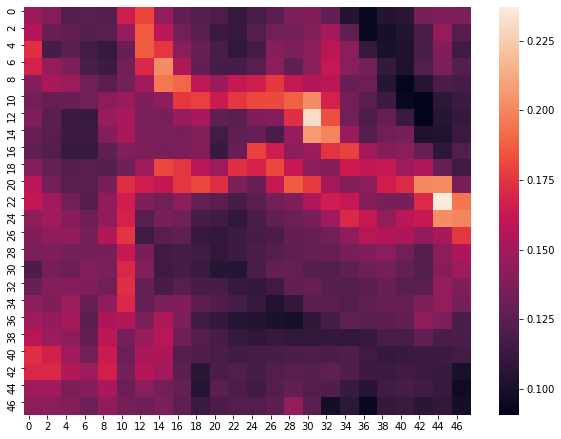

In [92]:
plt.figure(figsize=(10,7.5))
sns.heatmap(test_data[135, :, :, 4])

CPU times: user 336 ms, sys: 58.5 ms, total: 394 ms
Wall time: 118 ms


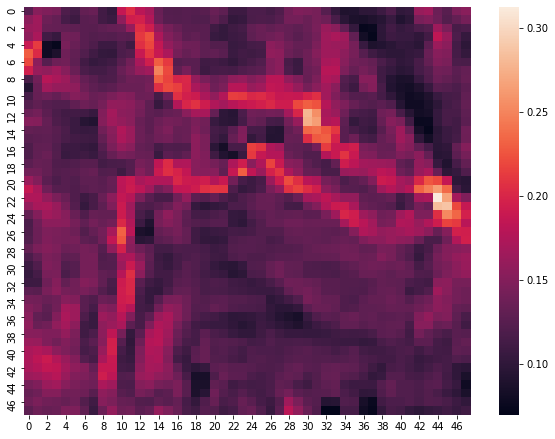

In [93]:
%time x = superresolve(test_data[135][np.newaxis], model)
plt.figure(figsize=(10,7.5))
sns.heatmap(x[0, ..., 4])